In [1]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as  plt
import tensorflow as tf
from tensorflow.keras import layers,models,optimizers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout,Flatten
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.applications import VGG16,VGG19
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
import warnings
warnings.simplefilter('ignore')
from PIL import Image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

base_dir = "/kaggle/input/aptos2019-blindness-detection"

# Loading Data + EDA

In [2]:
df = pd.read_csv("/kaggle/input/aptos2019-blindness-detection/train.csv")
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


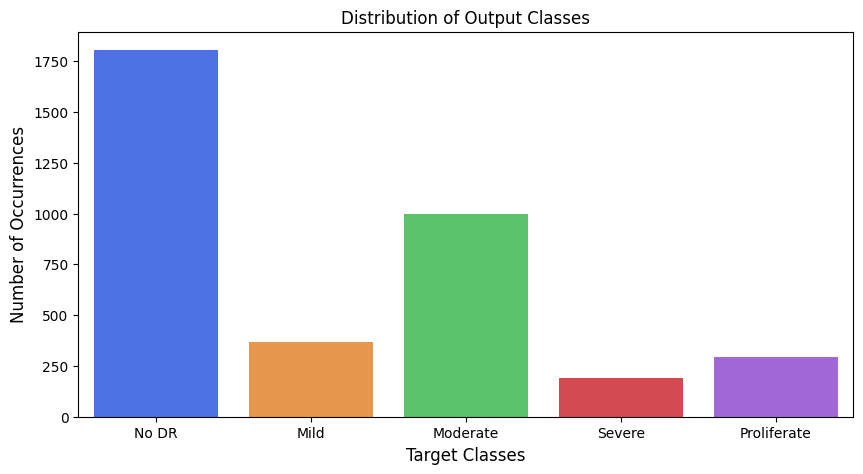

In [3]:
train_csv = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')
counts = train_csv['diagnosis'].value_counts()
class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferate']
for i,x in enumerate(class_list):
    counts[x] = counts.pop(i)

plt.figure(figsize=(10,5))
sns.barplot(x=counts.index, y=counts.values, alpha=0.8, palette='bright')
plt.title('Distribution of Output Classes')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Target Classes', fontsize=12)
plt.show()

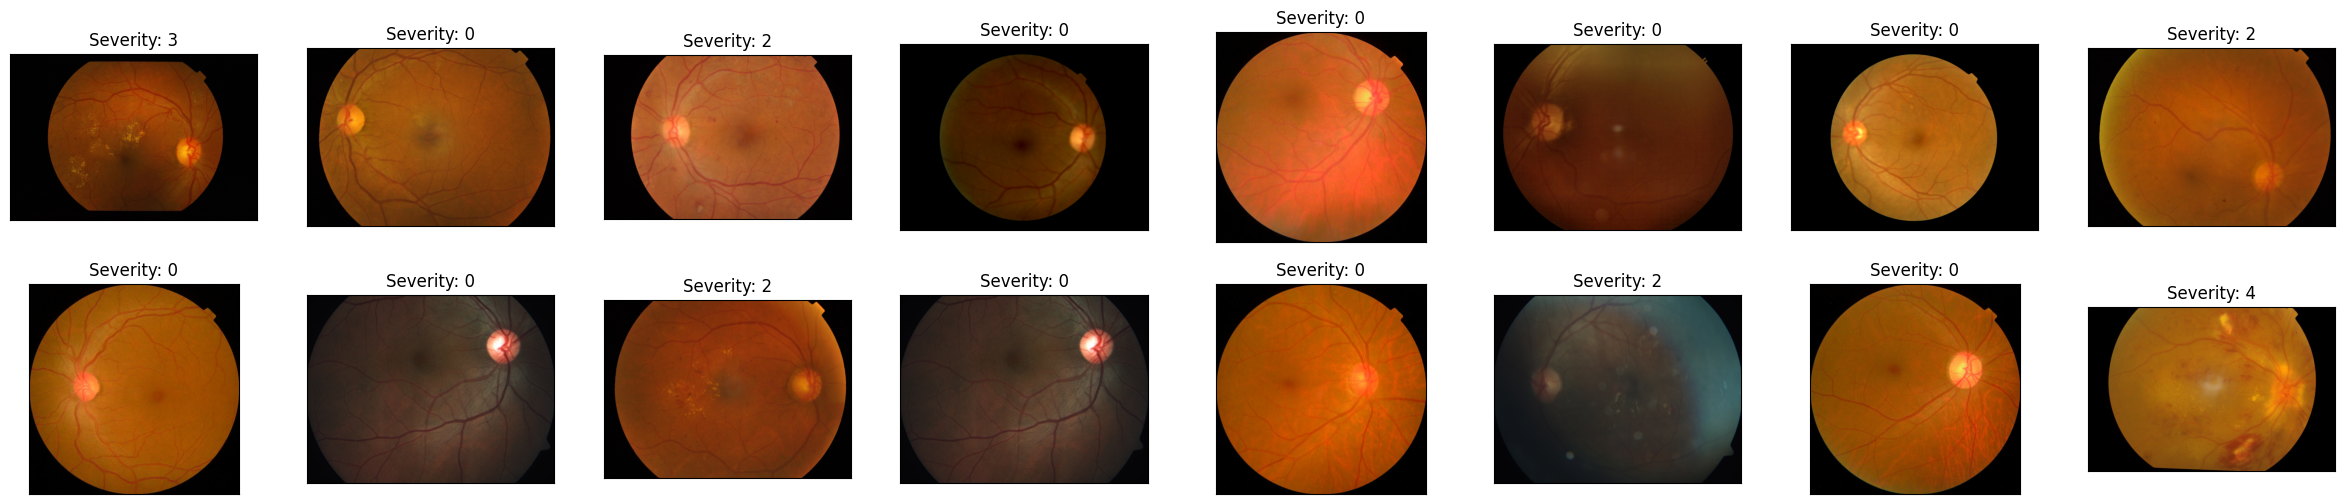

In [4]:
fig = plt.figure(figsize=(30, 6))
# display 20 images
train_imgs = os.listdir(base_dir+"/train_images")
for idx, img in enumerate(np.random.choice(train_imgs, 16)):
    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/train_images/" + img)
    plt.imshow(im)
    lab = train_csv.loc[train_csv['id_code'] == img.split('.')[0], 'diagnosis'].values[0]
    ax.set_title('Severity: %s'%lab)

# Visualizing Test Set

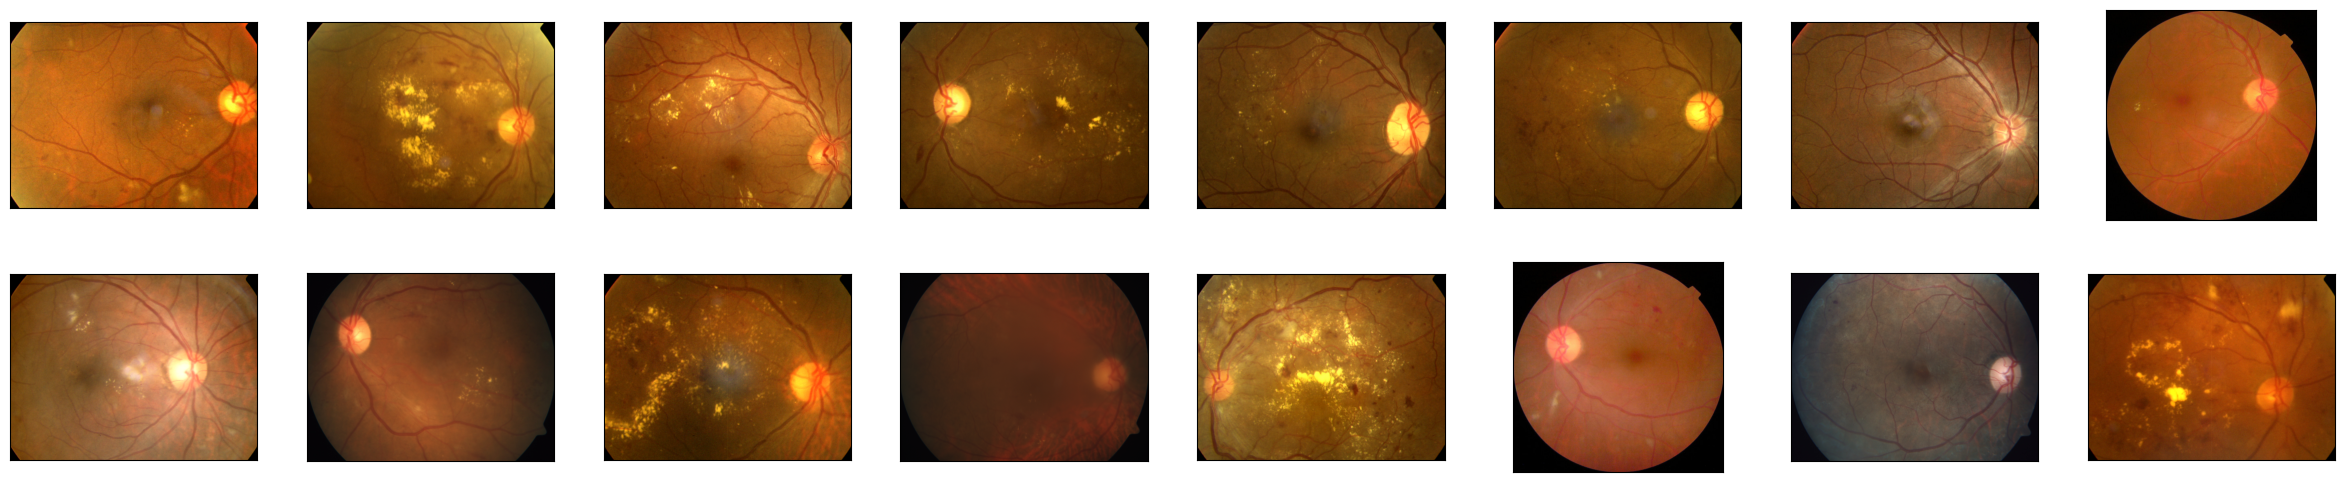

In [5]:
fig = plt.figure(figsize=(30, 6))
# display 20 images
test_imgs = os.listdir(base_dir+"/test_images")
for idx, img in enumerate(np.random.choice(test_imgs, 16)):
    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/test_images/" + img)
    plt.imshow(im)

# Data Processing

In [6]:
df["id_code"] = df["id_code"].apply(lambda x: x + ".png")

In [7]:
train_df = df.iloc[:3000,:]
test_df = df.iloc[3000:,:]

In [8]:
train_df['diagnosis'] = train_df['diagnosis'].astype('str')
gen = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    shear_range = 0.2,
    zoom_range = 0.2,
    rescale = 1/255.,
)
train_datagen = gen.flow_from_dataframe(
    train_df,
    directory = "/kaggle/input/aptos2019-blindness-detection/train_images",
    batch_size = 32,
    target_size = (224,224),
    seed = 42,
    x_col = 'id_code',
    y_col = 'diagnosis',
    class_mode = 'categorical'
)

Found 3000 validated image filenames belonging to 5 classes.


In [9]:
test_df['diagnosis'] = test_df['diagnosis'].astype('str')
gen = ImageDataGenerator(
    rescale = 1/255.,
)
test_datagen = gen.flow_from_dataframe(
    test_df,
    directory="/kaggle/input/aptos2019-blindness-detection/train_images",
    batch_size = 32,
    target_size = (224,224),
    seed = 42,
    x_col = 'id_code',
    y_col = 'diagnosis',
    class_mode = 'categorical'
)

Found 662 validated image filenames belonging to 5 classes.


# Modelling

In [10]:
model = Sequential()
mobilenet = MobileNet(include_top=False, weights='imagenet', input_shape=(224,224,3))
mobilenet.trainable = False  # Freeze pre-trained layers

model.add(mobilenet)
model.add(GlobalAveragePooling2D())

model.add(Flatten())

model.add(Dense(256, activation='elu'))
model.add(Dropout(0.3))

model.add(Dense(5, activation='softmax'))  # Output layer for 5 classes

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
loss = tf.keras.losses.CategoricalCrossentropy(
    label_smoothing = 0.001,
    name = 'categorical_crossentropy'
)

In [12]:
optimizer = Adam(learning_rate = 1e-4)

In [13]:
model.compile(optimizer = optimizer,loss=loss,metrics= ['categorical_accuracy'])

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 7, 7, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,492,549 (13.32 MB)

 Trainable params: 263,685 (1.01 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

# Model Training 

In [15]:
rlrong = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    mode='min',
    min_lr = 1e-5,
    patience = 2,
    verbose=1
)
estop = EarlyStopping(
    monitor = 'val_loss',
    mode= 'min',
    patience = 3,
    verbose = 1,
    restore_best_weights = True
)

In [16]:
history = model.fit(train_datagen,epochs = 20,verbose=1,validation_data = test_datagen,callbacks = [rlrong,estop])

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 499s 5s/step - categorical_accuracy: 0.4809 - loss: 1.4839 - val_categorical_accuracy: 0.6647 - val_loss: 0.8504 - learning_rate: 1.0000e-04
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 362s 4s/step - categorical_accuracy: 0.6779 - loss: 0.9053 - val_categorical_accuracy: 0.7508 - val_loss: 0.7016 - learning_rate: 1.0000e-04
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 361s 4s/step - categorical_accuracy: 0.7278 - loss: 0.7760 - val_categorical_accuracy: 0.7462 - val_loss: 0.6683 - learning_rate: 1.0000e-04
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 363s 4s/step - categorical_accuracy: 0.7012 - loss: 0.7915 - val_categorical_accuracy: 0.7674 - val_loss: 0.6377 - learning_rate: 1.0000e-04
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 364s 4s/step - categorical_accuracy: 0.7456 - loss: 0.6947 - val_categorical_accuracy: 0.7719 - val_loss: 0.6345 - learning_rate: 1.0000e-04
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 361s 4s/step - categorical_accuracy: 0.7378 - loss: 0.7023 - val_ca

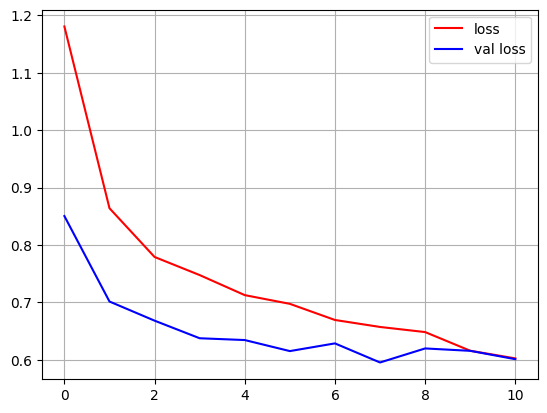

In [17]:
plt.plot(history.history['loss'],label='loss',color='red')
plt.plot(history.history['val_loss'],label='val loss',color='blue')
plt.legend()
plt.grid()
plt.show()

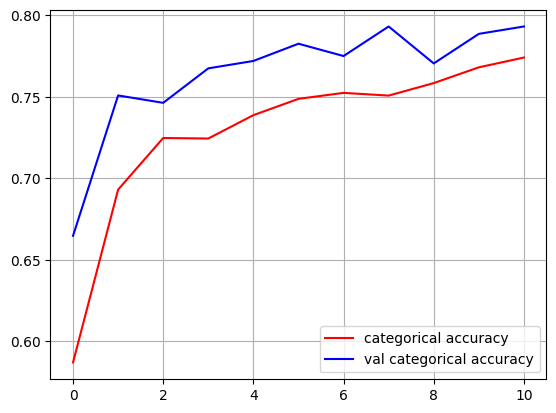

In [18]:
plt.plot(history.history['categorical_accuracy'],label='categorical accuracy',color='red')
plt.plot(history.history['val_categorical_accuracy'],label='val categorical accuracy',color='blue')
plt.legend()
plt.grid()
plt.show()

In [19]:
model.save('model_MobileNet.h5')